In [1]:
import numpy as np
import gym

import warnings # ignoring warning for comparing np array to string
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
env = gym.make('CartPole-v1')
n_x = env.observation_space.shape[0] # input size to NN (4)
n_h = 16                            # units in hidden layer
n_y = env.action_space.n             # output size of NN (2)

In [3]:
Q = {}
# initialising weights of Q network
Q['W1'] = np.random.randn(n_h, n_x) / np.sqrt(n_x) # Xavier initialisation 
Q['W2'] = np.random.randn(n_y, n_h) / np.sqrt(n_h)
# keeping fixed weights to generate targets when performing updates
Q['fW1'] = np.copy(Q['W1'])
Q['fW2'] = np.copy(Q['W2'])

In [4]:
epsilon = 1 # exploratry parameter for use in an epsilon-greedy policy
epsilon_decay = 0.99
min_epsilon = 0.1
gamma = 0.99 # discount factor for future rewards
learning_rate = 0.0001 

In [5]:
D = []   # experience replay data storage
N = 1000 # max capacity of D
batch_size = 32
fixed_Q_gap = 50 # iterations between freezing weights

In [6]:
def select_action(state):
    global epsilon
    choice = np.random.rand()
    if choice < epsilon:
        action = env.action_space.sample()
    else:
        action_values, _ = Q_forward(state, fixed=False)
        action = np.argmax(action_values)
    return action

In [7]:
def Q_forward(X, fixed=False):
    W1 = Q['fW1'] if fixed else Q['W1']
    W2 = Q['fW2'] if fixed else Q['W2']
    
    Z_h = np.dot(W1, X)
    A_h = np.maximum(0, Z_h) # ReLU activation
    Q_values = np.dot(W2, A_h)
    return Q_values, A_h

In [8]:
def sample_batch():
    X, Y = np.empty([n_x, 0]), np.empty([n_y, 0])
    indicies = np.random.choice(N, batch_size, replace=False)
    for i in indicies:
        state, action, reward, next_state = D[i]
        X = np.append(X, state, axis=1) 
        y, _ = Q_forward(state, fixed=False) # initially setting to state Q-values
        if next_state == 'T': # checking for terminal state
            y[action] = reward + gamma * 0
        else: # bootstrapping from fixed Q-Network
            next_state_Q_values, _ = Q_forward(next_state, fixed=True) 
            y[action] = reward + gamma * np.max(next_state_Q_values)
        Y = np.append(Y, y, axis=1)                   
    return X, Y

In [9]:
def backpropagate(X, Y):
    Qs, A_h = Q_forward(X, fixed=False)
    
    dQ  = (Y - Qs)
    dW2 = np.dot(dQ, A_h.T) / batch_size
    dA_h = np.dot(Q['W2'].T, dQ)
    dZ_h = dA_h
    dZ_h[A_h<=0] = 0 # derivative of ReLU
    dW1 = np.dot(dZ_h, X.T) / batch_size
    
    Q['W1'] = Q['W1'] + (learning_rate * dW1)
    Q['W2'] = Q['W2'] + (learning_rate * dW2)

In [10]:
def compute_cost(X, Y):
    Qs, _ = Q_forward(X, fixed=False)
    cost = np.sum(Y - Qs)**2 / (2 * batch_size)
    return cost

# Evaluating

In [11]:
%matplotlib inline
from matplotlib import pyplot as plt

In [12]:
rewards = []
total_steps = 0

In [13]:
# Deep Q-Learning
for episode in range(500):
    state = env.reset().reshape([n_x, 1])
    for t in range(200):
        action = select_action(state)
        next_state, reward, done, _ = env.step(action)
        next_state = 'T' if done else np.reshape(next_state, [n_x, 1])
        D.insert(0, (state, action, reward, next_state))
        D = D[:N]
        state = next_state
        total_steps += 1
        if total_steps >= N:
            X, Y = sample_batch()
            backpropagate(X, Y)
        if total_steps % fixed_Q_gap == 0:
            Q['fW1'] = np.copy(Q['W1'])
            Q['fW2'] = np.copy(Q['W2'])
        if done:
            if epsilon > min_epsilon:
                epsilon = epsilon * epsilon_decay
            rewards.append(t+1)
            if episode % 100 == 0:
                print('Episode: {}'.format(episode), end='\r')
            break
env.close()

Text(0, 0.5, 'Reward')

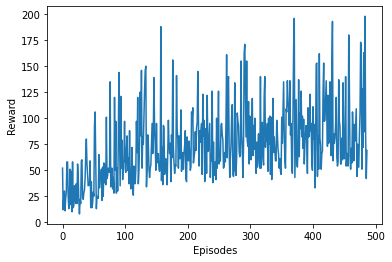

In [14]:
plt.plot(rewards)
plt.xlabel('Episodes')
plt.ylabel('Reward')

In [15]:
# Not exceptional, but it is clearly learning (max reward is 200). 
# If I come back to this I need a better way for testing hyperparameters.